In [ ]:
cat /proc/cpuinfo

Todos
* Recursive Feature Elimination
    * from sklearn.feature_selection import RFE

In [ ]:
client.close()

In [ ]:
from dask.distributed import Client, progress
client = Client(processes=False)
client

In [62]:
# from dask import delayed
# import dask.dataframe as dd
# import dask.array as da

import pandas as pd
import numpy as np


# Tools
from collections import Counter
import pickle
# import joblib
# svc_model = joblib.load('../models/SVC_20k.pkl')

# Sampling & Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Model Selection
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Features
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from xgboost import plot_importance

# Visualizations
from matplotlib import pyplot
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Load dataframe
df = pd.read_pickle('../data/df_cyclical_2018.pkl')

df.head()

,case_id,is_duplicate,opened,closed,updated,status_notes,responsible_agency,category,request_type,request_details,...,source,opened_year,opened_month_sin,opened_month_cos,opened_week_sin,opened_week_cos,opened_day_sin,opened_day_cos,opened_hour_sin,opened_hour_cos
810969,9995194,1,2018-12-31 10:42:22,2018-12-31 00:00:00,2018-12-31 00:00:00,Case Resolved - duplicate of 21375555 -,DPW - Bureau of Street Use and Mapping - G,General Request - PUBLIC WORKS,request_for_service,bsm - request_for_service,...,Integrated Agency,2018,-2.449294e-16,1.0,1.205367e-01,0.992709,0.000000,1.00000,0.500000,-0.866025
811474,9993791,0,2018-12-30 22:40:00,2018-12-30 23:13:06,2018-12-30 23:13:06,Case Resolved - Officer responded to request u...,Parking Enforcement Dispatch Queue,Parking Enforcement,Parking_on_Sidewalk,Black - Toyota Camry - NO PLATES,...,Mobile/Open311,2018,-2.449294e-16,1.0,-2.449294e-16,1.000000,-0.781831,0.62349,-0.500000,0.866025
811481,9993771,0,2018-12-30 22:18:00,2018-12-30 22:19:29,2018-12-30 22:19:29,Case is Invalid - Contact name and phone numbe...,Parking Enforcement Dispatch Queue,Parking Enforcement,Blocking_Driveway_Cite_Only,silver` - Mazda 3 Hatch back - 7YVN660,...,Phone,2018,-2.449294e-16,1.0,-2.449294e-16,1.000000,-0.781831,0.62349,-0.500000,0.866025
811482,9993764,0,2018-12-30 22:14:00,2018-12-30 23:12:50,2018-12-30 23:12:50,Case Resolved - Officer responded to request u...,Parking Enforcement Dispatch Queue,Parking Enforcement,Blocking_Driveway_Cite_Tow,Black - Prius - 6ZYG936,...,Mobile/Open311,2018,-2.449294e-16,1.0,-2.449294e-16,1.000000,-0.781831,0.62349,-0.500000,0.866025
811494,9993737,0,2018-12-30 21:53:14,2018-12-30 22:18:00,2018-12-30 22:18:00,Case Transferred - See encampment sr#9993757,311 Supervisor Queue,General Request - PUBLIC WORKS,request_for_service,bsm - request_for_service,...,Mobile/Open311,2018,-2.449294e-16,1.0,-2.449294e-16,1.000000,-0.781831,0.62349,-0.707107,0.707107


In [3]:
# Train and test splitting

# Columns to exclude
exclude_cols = [
    'is_duplicate', # Target variable
    'case_id',
    'opened', # Needs Feature Eng
    'closed', # Needs Feature Eng
    'updated',
    'responsible_agency', # Needs NLP
    'status_notes', # Needs NLP
    'request_type', # Needs NLP
    'request_details', # Needs NLP
    'address', # Needs NLP
#     'street', # Convert to 'category' type to get dummies
    'point'
]

# # Scale data using MinMax scaler
# # No need to standardize as all features are categorical (maybe scale lat/long....)
# scaler = MinMaxScaler()

# Predictor variables
X = df.drop(columns=exclude_cols, axis=0, inplace=False)

# Get dummies for categorical variables
X = pd.get_dummies(X, drop_first=True)

# Target variable
y = df['is_duplicate']

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=2020, 
                                                    stratify=y,  # Stratify to keep same class ratios
                                                    shuffle=True # Shuffle data since it's ordered chronologically
                                                   )
X_train.head()

,latitude,longitude,opened_month_sin,opened_month_cos,opened_week_sin,opened_week_cos,opened_day_sin,opened_day_cos,opened_hour_sin,opened_hour_cos,...,police_district_PARK,police_district_RICHMOND,police_district_SOUTHERN,police_district_TARAVAL,police_district_TENDERLOIN,source_Mobile/Open311,source_Other Department,source_Phone,source_Twitter,source_Web
1254989,37.7494,-122.4049,8.660254e-01,-0.500000,0.970942,-0.239316,-0.974928,-0.222521,-0.500000,-8.660254e-01,...,0,0,0,0,0,1,0,0,0,0
825764,37.7241,-122.4352,-2.449294e-16,1.000000,-0.120537,0.992709,0.974928,-0.222521,-1.000000,-1.836970e-16,...,0,0,0,0,0,1,0,0,0,0
1133920,37.7600,-122.4335,1.224647e-16,-1.000000,0.120537,-0.992709,0.433884,-0.900969,-1.000000,-1.836970e-16,...,0,0,0,0,0,0,0,0,0,1
1133478,37.7714,-122.4369,1.224647e-16,-1.000000,0.120537,-0.992709,-0.433884,-0.900969,0.965926,-2.588190e-01,...,0,0,0,0,0,0,0,0,0,1
880572,37.7238,-122.4356,-5.000000e-01,0.866025,-0.663123,0.748511,0.433884,-0.900969,0.866025,-5.000000e-01,...,0,0,0,0,0,1,0,0,0,0


# Feature Selection

In [4]:
def select_features(X_train, y_train, X_test):
    '''Returns X_train, X_test, and feature selection function'''
    fs = SelectKBest(score_func=f_classif, k=25)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [5]:
# Feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  51   52  126  211  340  377  424  442  466  553  735  754  804  831
  901  927  956 1198 1211 1249 1355 1451 1607 1621 1805 1913 1937 1945
 1955 2110 2404 2454 2458] are constant.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [17]:
# Feature scores
features_df = pd.DataFrame(data=[X_train.columns, fs.scores_.astype(int)]).transpose()
features_df.rename(columns={0: 'Feature', 1: 'ANOVA F-Value'}, inplace=True)
features_df.sort_values(by='ANOVA F-Value', ascending=False, inplace=True)
features_df.reset_index(drop=True, inplace=True)

# Select features above threshold
threshold = 1000
best_features_df = features_df[(features_df['ANOVA F-Value'] > threshold)]
best_features_df

,Feature,ANOVA F-Value
0,category_Encampments,20489
1,street_BERRY ST,6446
2,category_Street and Sidewalk Cleaning,4874
3,neighborhood_Showplace Square,4123
4,source_Phone,3749
5,opened_month_sin,3168
6,opened_week_sin,3055
7,police_district_SOUTHERN,3035
8,source_Mobile/Open311,2549
9,police_district_MISSION,2131


In [28]:
# Filter X_train & X_test with selected features
X_train = X_train.filter(items=best_features_df['Feature'])
X_test  = X_test.filter(items=best_features_df['Feature'])

# Clean column names
X_train.columns = X_train.columns.str.strip().str.lower().str.replace(
    ' ', '_').str.replace('(', '').str.replace(')', '')

X_test.columns = X_test.columns.str.strip().str.lower().str.replace(
    ' ', '_').str.replace('(', '').str.replace(')', '')

((424648, 15), (106162, 15))

In [29]:
print('df\t', df.shape)
print('X_train\t', X_train.shape)
print('X_test\t', X_test.shape)
print('y_train\t', y_train.shape)
print('y_test\t', y_test.shape)

df	 (530810, 28)
X_train	 (424648, 15)
X_test	 (106162, 15)
y_train	 (424648,)
y_test	 (106162,)


# Class Balancing

In [31]:
# Target variable
target_count = df['is_duplicate'].value_counts()

# Print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 3)*100}')

Class 0: 474425
Class 1: 56385
Proportion: 8.41 : 1
Percentage of Majority Class: 89.4


In [ ]:
# USE DASK from here on out

## Oversampling

In [41]:
# A ratio of .5 is saying that 50% of my data is simulated
# Trevor noted that .2 would be good but let's try different ratios
smote = SMOTE(random_state=2020)
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

# Summarize the new class distribution
Counter(y_train_smote)

Counter({0: 379540, 1: 379540})

## Undersampling

In [63]:
# # Define the undersampling method – RandomUnderSampler
rndm_under = RandomUnderSampler(random_state=2020)

# Transform the dataset
X_train_under, y_train_under = rndm_under.fit_sample(X_train, y_train)

# # Summarize the new class distribution
# Counter(y_train_under)

In [39]:
# # Define the undersampling method – NearMiss
# # Selects the closest examples from the majority class for each minority class.
# undersample = NearMiss(version=3, n_neighbors_ver3=3)

# # Transform the dataset
# X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

# # Summarize the new class distribution
# Counter(y_train_under)

/opt/conda/lib/python3.7/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:175: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


Counter({0: 10976, 1: 45108})

# Modeling

Objective: Maximize ROC AUC Score as both recall and precision are equally important and the classes are imbalanced

In [34]:
# Create list of model and performance
model_performance = []
models_optimized = []

User RandomizedSearchCV instead:
https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85


## Baseline Models

In [ ]:
# #Dummy Classifier
# from sklearn.dummy import DummyClassifier
# clf = DummyClassifier(strategy= 'most_frequent').fit(X_train_under, y_train_under)
# y_pred = clf.predict(X_test)

# #Distribution of y test
# print('y actual\t:', Counter(y_test))

# #Distribution of y predicted
# print('y predicted\t:', Counter(y_pred))

# # Confusion matrix
# print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, y_pred)))

In [42]:
base_models = []

# Instantiate the models
base_models.append(('LogisticRegression', LogisticRegression(solver='liblinear')))
base_models.append(('KNeighbors', KNeighborsClassifier()))
base_models.append(('RandomForest', RandomForestClassifier(n_estimators=10)))
base_models.append(('XGBoost', XGBClassifier()))

cv_results = []
names = []

# Cross Validate - 5 fold
for name, model in base_models:
    names.append(name)
    cv_results.append(np.round_(cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring='roc_auc'), 3))

for i in range(len(names)):
    print(names[i], round(cv_results[i].mean(), 3))

LogisticRegression 0.714
KNeighbors 0.722
RandomForest 0.786
XGBoost 0.781


In [36]:
# Identify the models that work best without any GridSearchCV
# Plot the ROC Curves
# Undersampling (Don't use synthetic data)
# How to predict duplicates?
## More like unsupervised learning... 
## Create a function – given a point, identify a case that this is more similar to...


In [37]:
# # Save models
# with open(f'../models/{name}_20k.pkl', 'wb') as f: # how can I save the model for later use?ii
#     pickle.dump(model, f)

## Logistic Regression

In [43]:
# Grid searching key hyperparameters for logistic regression

# Instantiate model and sampler
lg_model = LogisticRegression()
smote = SMOTE(random_state=2020)

# Construct pipeline
steps = [('smt', smote), ('lgr', lg_model)]
pipeline = Pipeline(steps)

# Define parameter grid values to be searched
param_grid = {
    'smt__random_state': [2020],
    'lgr__solver': ['saga', 'liblinear'],
    'lgr__penalty': ['l1', 'l2'],
    'lgr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Use stratify version of k-fold to keep class imbalance ratio
k_fold = StratifiedKFold(n_splits=3, shuffle = True, random_state=2020)

# Cross Validation
# lg_grid = GridSearchCV(pipeline, param_grid=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')
lg_rndm = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')

# Train with balanced classes
grid_result = lg_rndm.fit(X_train_smote, y_train_smote) # Should I use X_train, y_train here?

# Summarize results
print(f'Best Score: {round(grid_result.best_score_, 3)}\nParams: {grid_result.best_params_}\n')

mean_train = grid_result.cv_results_['mean_train_score']
mean_test = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean_tr, mean_ts, param in zip(mean_train, mean_test, params):
    print(f'Train {round(mean_tr, 3)}\tTest {round(mean_ts, 3)}\tParams: {param}')
    
# # Examine the best model
# print(lg_grid.best_score_)
# print(lg_grid.best_params_)

Best Score: 0.714
Params: {'smt__random_state': 2020, 'lgr__solver': 'saga', 'lgr__penalty': 'l2', 'lgr__C': 10}

Train 0.714	Test 0.714	Params: {'smt__random_state': 2020, 'lgr__solver': 'saga', 'lgr__penalty': 'l2', 'lgr__C': 1}
Train 0.714	Test 0.714	Params: {'smt__random_state': 2020, 'lgr__solver': 'liblinear', 'lgr__penalty': 'l2', 'lgr__C': 1}
Train 0.714	Test 0.714	Params: {'smt__random_state': 2020, 'lgr__solver': 'saga', 'lgr__penalty': 'l2', 'lgr__C': 10}
Train 0.714	Test 0.714	Params: {'smt__random_state': 2020, 'lgr__solver': 'saga', 'lgr__penalty': 'l1', 'lgr__C': 0.01}
Train 0.714	Test 0.714	Params: {'smt__random_state': 2020, 'lgr__solver': 'liblinear', 'lgr__penalty': 'l1', 'lgr__C': 0.01}
Train 0.714	Test 0.714	Params: {'smt__random_state': 2020, 'lgr__solver': 'liblinear', 'lgr__penalty': 'l1', 'lgr__C': 1}
Train 0.714	Test 0.714	Params: {'smt__random_state': 2020, 'lgr__solver': 'saga', 'lgr__penalty': 'l2', 'lgr__C': 100}
Train 0.714	Test 0.714	Params: {'smt__rando

In [53]:
# Instantiate model with best paramaters
lg_best = LogisticRegression(C=10, penalty='l2', solver='saga', random_state=2020) # Check the params

# Train with balanced classes
lg_best.fit(X_train_smote, y_train_smote)

# Get predictions
lg_best_preds = lg_best.predict(X_test)
# lg_best_y_score = lg_best.predict_proba(X_test)

# Get ROC AUC Score, precision, recall, f1-score
accuracy  = round(accuracy_score(y_test, lg_best_preds), 3)
roc_auc   = round(roc_auc_score(y_test, lg_best_preds), 3)
precision = round(precision_score(y_test, lg_best_preds), 3)
recall    = round(recall_score(y_test, lg_best_preds), 3)
f1        = round(f1_score(y_test, lg_best_preds), 3)

print(f'Accuracy  : {accuracy}')
print(f'ROC_AUC   : {roc_auc}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {f1}')

# Confusion matrix
print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, lg_best_preds)))

Accuracy  : 0.692
ROC_AUC   : 0.651
Precision : 0.193
Recall    : 0.598
F-score   : 0.292

Confusion Matrix
[[66746 28139]
 [ 4536  6741]]


In [54]:
# # Add model and accuracy dict to list
# model_performance.append(dict([
#     ('Model', 'Logistic Regression'),
#     ('ROC AUC', round(roc_auc, 3)),
#     ('Precision', round(precision, 3)),
#     ('Recall', round(recall, 3)),
#     ('f1', round(f1_score, 3))
#      ]))

# # Add model to list
# models_optimized.append('Logistic Regression')

## KNN

In [45]:
# Grid searching key hyperparameters for KNN

# Instantiate model and SMOTE
knn_model = KNeighborsClassifier()
smote = SMOTE(random_state=2020)

# Construct pipeline
steps = [('smt', smote), ('knn', knn_model)]
pipeline = Pipeline(steps)

# Define parameter grid values to be searched
param_grid = {
    'smt__random_state': [2020],
    'knn__n_neighbors' : [3, 5, 7]
}

# Use stratify version of k-fold to keep class imbalance ratio
k_fold = StratifiedKFold(n_splits=3, shuffle = True, random_state=2020)

# Cross Validation
# knn_grid = GridSearchCV(pipeline, param_grid=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')
knn_rndm = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')

# Train with balanced classes
grid_result = knn_rndm.fit(X_train_smote, y_train_smote) # Should I use X_train, y_train here?

# Summarize results
print(f'Best Score: {round(grid_result.best_score_, 3)}\nParams: {grid_result.best_params_}\n')

mean_train = grid_result.cv_results_['mean_train_score']
mean_test = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean_tr, mean_ts, param in zip(mean_train, mean_test, params):
    print(f'Train {round(mean_tr, 3)}\tTest {round(mean_ts, 3)}\tParams: {param}')
    
# # Examine the best model
# print(knn_grid.best_score_)
# print(knn_grid.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Score: 0.732
Params: {'smt__random_state': 2020, 'knn__n_neighbors': 7}

Train 0.713	Test 0.706	Params: {'smt__random_state': 2020, 'knn__n_neighbors': 3}
Train 0.732	Test 0.725	Params: {'smt__random_state': 2020, 'knn__n_neighbors': 5}
Train 0.739	Test 0.732	Params: {'smt__random_state': 2020, 'knn__n_neighbors': 7}


In [46]:
# Instantiate model with best paramaters
knn_best = KNeighborsClassifier(n_neighbors=7)

# Train with balanced classes
knn_best.fit(X_train_smote, y_train_smote)

# Get predictions
knn_best_preds = knn_best.predict(X_test)
# knn_best_y_score = knn_best.predict_proba(X_test)

# Get ROC AUC Score, precision, recall, f1-score
accuracy  = round(accuracy_score(y_test,  knn_best_preds), 3)
roc_auc   = round(roc_auc_score(y_test,   knn_best_preds), 3)
precision = round(precision_score(y_test, knn_best_preds), 3)
recall    = round(recall_score(y_test,    knn_best_preds), 3)
f1        = round(f1_score(y_test,        knn_best_preds), 3)

print(f'Accuracy  : {accuracy}')
print(f'ROC_AUC   : {roc_auc}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {f1}')

# Confusion matrix
print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, knn_best_preds)))

Accuracy  : 0.742
ROC_AUC   : 0.656
Precision : 0.217
Recall    : 0.545
F-score   : 0.31

Confusion Matrix
[[72657 22228]
 [ 5128  6149]]


In [48]:
# # Add model and accuracy dict to list
# model_performance.append(dict([
#     ('Model', 'KNN'),
#     ('ROC AUC', round(roc_auc, 3)),
#     ('Precision', round(precision, 3)),
#     ('Recall', round(recall, 3)),
#     ('f1', round(f1_score, 3))
#      ]))

# # Add model to list
# models_optimized.append('KNN')

## Random Forest

In [55]:
# Grid searching key hyperparameters for Random Forest

# Instantiate model and SMOTE
rf_model = RandomForestClassifier()
smote = SMOTE(random_state=2020)

# Construct pipeline
steps = [('smt', smote), ('rfc', rf_model)]
pipeline = Pipeline(steps)

# Define parameter grid values to be searched
param_grid = {
    'smt__random_state': [2020],
    'rfc__n_estimators': [50, 100, 150, 200, 1000],
    'rfc__max_depth' : [2, 3, 4],
    'rfc__max_features' : [5, 10, 15],
    'rfc__criterion' : ['gini', 'entropy'],
    'rfc__random_state' :[2020]
}

# Use stratify version of k-fold to keep class imbalance ratio
k_fold = StratifiedKFold(n_splits=3, shuffle = True, random_state=2020)

# Cross Validation
# rf_grid = GridSearchCV(pipeline, param_grid=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')
rf_rndm = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')

# Train with balanced classes
grid_result = rf_rndm.fit(X_train_smote, y_train_smote) # Should I use X_train, y_train here?

# Summarize results
print(f'Best Score: {round(grid_result.best_score_, 3)}\nParams: {grid_result.best_params_}\n')

mean_train = grid_result.cv_results_['mean_train_score']
mean_test = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean_tr, mean_ts, param in zip(mean_train, mean_test, params):
    print(f'Train {round(mean_tr, 3)}\tTest {round(mean_ts, 3)}\tParams: {param}')
    
# # Examine the best model
# print(rf_grid.best_score_)
# print(rf_grid.best_params_)

Best Score: 0.717
Params: {'smt__random_state': 2020, 'rfc__random_state': 2020, 'rfc__n_estimators': 100, 'rfc__max_features': 10, 'rfc__max_depth': 3, 'rfc__criterion': 'gini'}

Train 0.705	Test 0.705	Params: {'smt__random_state': 2020, 'rfc__random_state': 2020, 'rfc__n_estimators': 200, 'rfc__max_features': 5, 'rfc__max_depth': 2, 'rfc__criterion': 'gini'}
Train 0.713	Test 0.713	Params: {'smt__random_state': 2020, 'rfc__random_state': 2020, 'rfc__n_estimators': 100, 'rfc__max_features': 5, 'rfc__max_depth': 3, 'rfc__criterion': 'entropy'}
Train 0.717	Test 0.717	Params: {'smt__random_state': 2020, 'rfc__random_state': 2020, 'rfc__n_estimators': 100, 'rfc__max_features': 10, 'rfc__max_depth': 3, 'rfc__criterion': 'gini'}
Train 0.713	Test 0.713	Params: {'smt__random_state': 2020, 'rfc__random_state': 2020, 'rfc__n_estimators': 100, 'rfc__max_features': 15, 'rfc__max_depth': 4, 'rfc__criterion': 'gini'}
Train 0.701	Test 0.701	Params: {'smt__random_state': 2020, 'rfc__random_state': 202

In [56]:
# Instantiate model with best paramaters
rf_best = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=3, max_features=10, random_state=2020)

# Train with balanced classes
rf_best.fit(X_train_smote, y_train_smote)

# Get predictions
rf_best_preds = rf_best.predict(X_test)
# rf_best_y_score = rf_best.predict_proba(X_test)

# Get ROC AUC Score, precision, recall, f1-score
accuracy  = round(accuracy_score(y_test,  rf_best_preds), 3)
roc_auc   = round(roc_auc_score(y_test,   rf_best_preds), 3)
precision = round(precision_score(y_test, rf_best_preds), 3)
recall    = round(recall_score(y_test,    rf_best_preds), 3)
f1        = round(f1_score(y_test,        rf_best_preds), 3)

print(f'Accuracy  : {accuracy}')
print(f'ROC_AUC   : {roc_auc}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {f1}')

# Confusion matrix
print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, rf_best_preds)))

Accuracy  : 0.753
ROC_AUC   : 0.649
Precision : 0.219
Recall    : 0.518
F-score   : 0.308

Confusion Matrix
[[74081 20804]
 [ 5437  5840]]


In [57]:
# # Add model and accuracy dict to list
# model_performance.append(dict([
#     ('Model', 'Random Forest'),
#     ('ROC AUC', round(roc_auc, 3)),
#     ('Precision', round(precision, 3)),
#     ('Recall', round(recall, 3)),
#     ('F1', round(f1_score, 3))
#      ]))

# # Add model to list
# models_optimized.append('Random Forest')

## XGBoost

In [61]:
# Grid searching key hyperparameters for XGBoost

# Instantiate model and SMOTE
xgb_model = XGBClassifier()
smote = SMOTE(random_state=2020)

# Construct pipeline
steps = [('smt', smote), ('xgb', xgb_model)]
pipeline = Pipeline(steps)

# Define parameter grid values to be searched
param_grid = {
    'smt__random_state': [2020],
    'xgb__n_estimators': [100, 250, 500, 1000], 
    'xgb__max_depth': [3, 4, 5], 
    'xgb__learning_rate': [0.001, 0.01, 0.1]
}

# Use stratify version of k-fold to keep class imbalance ratio
k_fold = StratifiedKFold(n_splits=3, shuffle = True, random_state=2020)

# Cross Validation
# xgb_grid = GridSearchCV(pipeline, param_grid=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')
xgb_rndm = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=k_fold, n_jobs=-1, return_train_score=True, scoring='roc_auc')

# Train with balanced classes
grid_result = xgb_rndm.fit(X_train_smote, y_train_smote) # Should I use X_train, y_train here?

# Summarize results
print(f'Best Score: {round(grid_result.best_score_, 3)}\nParams: {grid_result.best_params_}\n')

mean_train = grid_result.cv_results_['mean_train_score']
mean_test = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean_tr, mean_ts, param in zip(mean_train, mean_test, params):
    print(f'Train {round(mean_tr, 3)}\tTest {round(mean_ts, 3)}\tParams: {param}')
    
# # Examine the best model
# print(lg_grid.best_score_)
# print(lg_grid.best_params_)

Best Score: 0.767
Params: {'xgb__n_estimators': 250, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.1, 'smt__random_state': 2020}

Train 0.717	Test 0.717	Params: {'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'smt__random_state': 2020}
Train 0.763	Test 0.762	Params: {'xgb__n_estimators': 100, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1, 'smt__random_state': 2020}
Train 0.762	Test 0.762	Params: {'xgb__n_estimators': 1000, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.01, 'smt__random_state': 2020}
Train 0.73	Test 0.73	Params: {'xgb__n_estimators': 250, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'smt__random_state': 2020}
Train 0.745	Test 0.745	Params: {'xgb__n_estimators': 250, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.01, 'smt__random_state': 2020}
Train 0.727	Test 0.727	Params: {'xgb__n_estimators': 500, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.001, 'smt__random_state': 2020}
Train 0.746	Test 0.746	Params: {'xgb__n_estimators': 500, 'xgb__max_

In [64]:
# Instantiate model with best paramaters
xgb_best = XGBClassifier(n_estimators=250, max_depth=4, learning_rate=0.1)

# Train with balanced classes
xgb_best.fit(X_train_smote, y_train_smote)

# Get predictions
xgb_best_preds = xgb_best.predict(X_test)
# xgb_best_y_score = xgb_best.predict_proba(X_test)

# Get ROC AUC Score, precision, recall, f1-score
accuracy  = round(accuracy_score(y_test,  rf_best_preds), 3)
roc_auc   = round(roc_auc_score(y_test,   rf_best_preds), 3)
precision = round(precision_score(y_test, rf_best_preds), 3)
recall    = round(recall_score(y_test,    rf_best_preds), 3)
f1        = round(f1_score(y_test,        rf_best_preds), 3)

print(f'Accuracy  : {accuracy}')
print(f'ROC_AUC   : {roc_auc}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {f1}')

# Confusion matrix
print('\nConfusion Matrix\n' + str(confusion_matrix(y_test, xgb_best_preds)))

Accuracy  : 0.753
ROC_AUC   : 0.649
Precision : 0.219
Recall    : 0.518
F-score   : 0.308

Confusion Matrix
[[71271 23614]
 [ 4643  6634]]


In [65]:
# # Add model and accuracy dict to list
# model_performance.append(dict([
#     ('Model', 'XGBoost'),
#     ('ROC AUC', round(roc_auc, 3)),
#     ('Precision', round(precision, 3)),
#     ('Recall', round(recall, 3)),
#     ('F1', round(f1, 3))
#      ]))

# # Add model to list
# models_optimized.append('XGBoost')

# Feature Importance

Text(0.5, 1.0, 'Feature Importance')

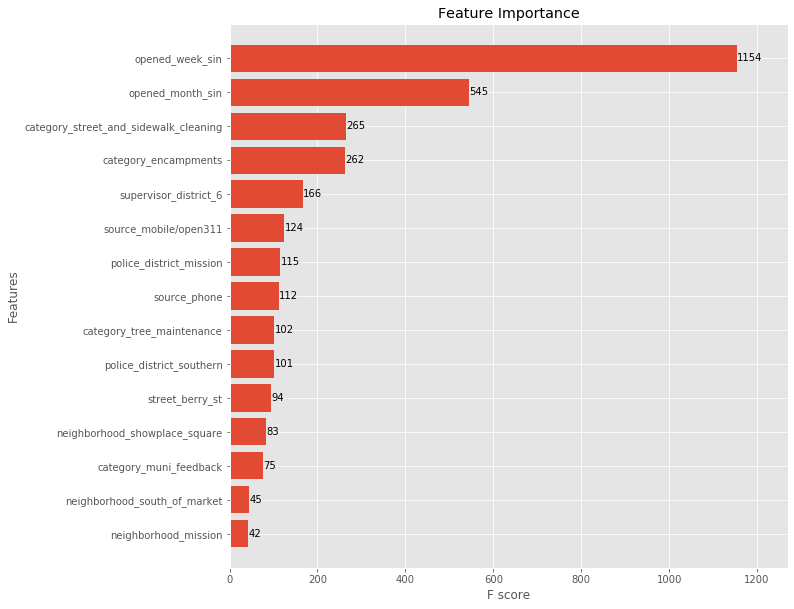

In [66]:
# Feature Importance – XGBoost
fig, ax = plt.subplots(figsize=(10,10))
xgb_best.get_booster().feature_names = list(X_test.columns)
plot_importance(xgb_best.get_booster(), max_num_features=15, height=0.8, ax=ax)
plt.title('Feature Importance')

# plt.savefig('feature_importance.png', bbox_inches='tight');

# Model Comparison

In [67]:
def plot_roc_curves(classifiers, X_train, y_train, X_test, y_test, sampler = None):
    """
        Function for plotting roc curves of classifiers for comparison
        
        :param classifiers: dictionary of classifiers
        :param sampler: sampling method to use e.g. smote
        
        :returns fpr: an array of false positive rate values from roc_curve
        :returns tpr: an array of true positive rate values from roc_curve
        :returns thresholds: an array of threshold values from roc_curve
        :returns roc_auc: roc_auc scores for each classifier in classifiers
        
        https://github.com/kevinchiv/Predicting-Kickstarter-Success/blob/master/02%20-%20Classification%20Modeling.ipynb
    """

    fpr, tpr, thresholds = {}, {}, {}
    roc_auc = {}


    for classifier_name, classifier in classifiers.items():

        #set n_jobs = -1 for faster performance
        classifier = classifier.set_params(n_jobs = -1)

#         if sampler:
#             sampler.set_params(random_state = 42, n_jobs = -1)

        steps = [('sampling', sampler),
                 (classifier_name, classifier)]

        model = Pipeline(steps)

        model.fit(X_train, y_train)

        y_proba = model.predict_proba(X_test)[:,1]

        fpr[classifier_name], tpr[classifier_name], thresholds[classifier_name] = roc_curve(y_test, y_proba)

        roc_auc[classifier_name] = round(auc(fpr[classifier_name], tpr[classifier_name]), 3)

        print(classifier_name + ' roc_auc score: ' + str(roc_auc[classifier_name]))


    plt.figure(figsize=(8, 8))

    for classifier_name, classifier in classifiers.items():
        sns.lineplot(fpr[classifier_name], tpr[classifier_name], err_style = None);

    midline_points = np.arange(0, 1.05, 0.05) 

    plt.plot(midline_points, midline_points, linestyle ='--', color = 'black');
    plt.title("ROC Curves for Different Classification Models", y =1.05, fontsize = 16);
    plt.xlabel('FPR', fontsize = 12, x = 1.05);
    plt.ylabel('TPR', fontsize = 12, rotation =0, y = 1.05);
    plt.legend(list(zip(classifiers.keys(), roc_auc.values())));

    return fpr, tpr, thresholds, roc_auc

KNN roc_auc score: 0.708
LGR roc_auc score: 0.71
RFC roc_auc score: 0.714
XGB roc_auc score: 0.744
Ensemble roc_auc score: 0.731


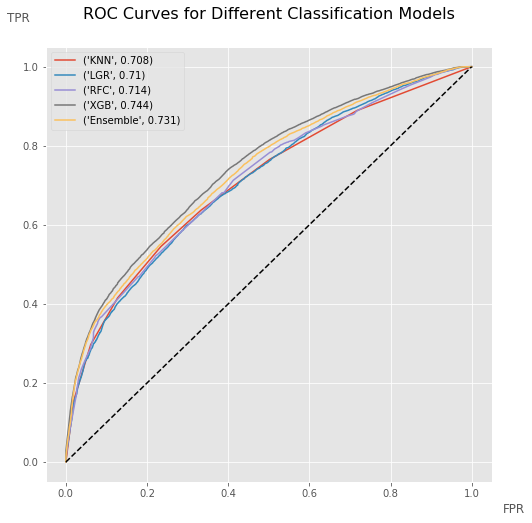

In [68]:
classifiers = {'KNN': knn_best, 
               'LGR': lg_best, 
               'RFC': rf_best, 
               'XGB': xgb_best,
               'Ensemble': VotingClassifier(estimators=[('lr', lg_best), ('rf', rf_best), ('xgb', xgb_best)],
                                            voting='soft', weights=[1, 1, 1])
              }

fpr, tpr, thresholds, roc_auc = plot_roc_curves(classifiers, X_train_smote, y_train_smote, X_test, y_test)

## Confusion Matrix for Test Dataset

In [ ]:
# # Print confusion matrix for XGBoost
# xgb_confusion = confusion_matrix(y_test, test_pred_smote)

# plt.figure(dpi=125)
# sns.heatmap(xgb_confusion, annot=True, fmt='g', square=True, cbar=False,
#             xticklabels=['no duplicate', 'is duplicate'],
#             yticklabels=['no duplicate', 'is duplicate'])

# plt.title('Confusion Matrix - Test Dataset\nXGBoost', pad=20)
# plt.xlabel('Predicted\n', labelpad=20)
# plt.ylabel('Actual\n', labelpad=20);